<a href="https://colab.research.google.com/github/Apurvchaurasiya/ViT_replication_in_torch/blob/main/VitFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as dataloader
import torch.nn as nn

In [98]:
# transformation for PIL to tensor format
transformation_operation = transforms.Compose([transforms.ToTensor()])

In [99]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform = transformation_operation)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform = transformation_operation)

In [100]:
# define variable
num_classes = 10
batch_size = 64
num_channels = 1
img_size = 28
patch_size = 7
num_patches = ( img_size // patch_size ) ** 2
print(num_patches)
embedding_dim = 64
attention_heads = 4
transformer_blocks = 4
mlp_hidden_nodes = 128
learning_rate = 0.001
epochs = 5

16


In [101]:
# define dataset batches
train_loader = dataloader.DataLoader(train_dataset, batch_size =batch_size, shuffle = True)
val_loader = dataloader.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [102]:
# Patch embedding
class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embed = nn.Conv2d(num_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
      #patchembed
    x = self.patch_embed(x)
    x = x.flatten(2)
    x = x.transpose(1,2)

    return x



In [103]:
# transformer encoder

class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(embedding_dim)
    self.layer_norm2 = nn.LayerNorm(embedding_dim)
    self.multihead_attention = nn.MultiheadAttention(embedding_dim, attention_heads, batch_first=True)
    self.mlp = nn.Sequential(
        nn.Linear(embedding_dim, mlp_hidden_nodes),
        nn.GELU(),
        nn.Linear(mlp_hidden_nodes, embedding_dim),
    )
  def forward(self, x):
    residual1 = x
    x = self.layer_norm1(x)
    x = self.multihead_attention(x, x, x)[0]
    x = x + residual1

    residual2 = x
    x = self.layer_norm2(x)
    x = self.mlp(x)
    x = x + residual2

    return x

In [104]:
# MLP_head


class MLP_head(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_norm1 = nn.LayerNorm(embedding_dim)
    self.mlp_head = nn.Linear(embedding_dim, num_classes)

  def forward(self, x):
    x = self.layer_norm1(x)
    x = self.mlp_head(x)


    return x

In [105]:
class VisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding = PatchEmbedding()
    self.cls_token = nn.Parameter(torch.randn(1,1,embedding_dim))
    self.position_embedding = nn.Parameter(torch.randn(1,1+num_patches,embedding_dim))
    self.transformer_blocks = nn.Sequential(*[TransformerEncoder() for _ in range(transformer_blocks)])
    self.mlp_head = MLP_head()


  def forward(self, x):
    x = self.patch_embedding(x)
    B = x.size(0)
    class_tokens = self.cls_token.expand(B, -1, -1)
    x = torch.cat((class_tokens, x), dim=1)
    x = x + self.position_embedding
    x = self.transformer_blocks(x)
    x = x[:,0]
    x = self.mlp_head(x)

    return x

    # cls token
    #pe


In [106]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [107]:

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    correct_epoch = 0
    total_samples = 0

    print(f"\nEpoch {epoch+1}/{epochs}")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)                 # logits: [B, num_classes]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()                        # <-- IMPORTANT: update weights


        batch_loss = loss.item()
        total_loss += batch_loss

        preds = outputs.argmax(dim=1)
        correct = (preds == labels).sum().item()
        batch_size = labels.size(0)

        correct_epoch += correct
        total_samples += batch_size

        batch_acc = 100.0 * correct / batch_size
        if batch_idx % 100 == 0:
            print(f" Batch {batch_idx+1:4d}: Loss = {batch_loss:.4f}, Batch Acc = {batch_acc:.2f}%")


    avg_loss = total_loss / len(train_loader) if len(train_loader) > 0 else 0.0
    epoch_acc = 100.0 * correct_epoch / total_samples if total_samples > 0 else 0.0

    print(f"==> Epoch {epoch+1} Summary: Avg Loss = {avg_loss:.4f}, Train Acc = {epoch_acc:.2f}%")



Epoch 1/5
 Batch    1: Loss = 2.5479, Batch Acc = 6.25%
 Batch  101: Loss = 0.5992, Batch Acc = 82.81%
 Batch  201: Loss = 0.3699, Batch Acc = 87.50%
 Batch  301: Loss = 0.1279, Batch Acc = 96.88%
 Batch  401: Loss = 0.2930, Batch Acc = 92.19%
 Batch  501: Loss = 0.2270, Batch Acc = 89.06%
 Batch  601: Loss = 0.2082, Batch Acc = 96.88%
 Batch  701: Loss = 0.1796, Batch Acc = 92.19%
 Batch  801: Loss = 0.1832, Batch Acc = 93.75%
 Batch  901: Loss = 0.1056, Batch Acc = 96.88%
==> Epoch 1 Summary: Avg Loss = 0.3656, Train Acc = 88.36%

Epoch 2/5
 Batch    1: Loss = 0.1834, Batch Acc = 93.75%
 Batch  101: Loss = 0.0436, Batch Acc = 98.44%
 Batch  201: Loss = 0.1715, Batch Acc = 92.19%
 Batch  301: Loss = 0.0677, Batch Acc = 98.44%
 Batch  401: Loss = 0.0871, Batch Acc = 96.88%
 Batch  501: Loss = 0.2983, Batch Acc = 92.19%
 Batch  601: Loss = 0.0624, Batch Acc = 98.44%
 Batch  701: Loss = 0.0864, Batch Acc = 95.31%
 Batch  801: Loss = 0.1535, Batch Acc = 93.75%
 Batch  901: Loss = 0.0776,

In [110]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    preds = outputs.argmax(dim=1)
    correct += (preds == labels).sum().item()
    total += labels.size(0)

test_acc = 100.0 * correct / total
print(f"\n==> Val Accuracy: {test_acc:.2f}%")


==> Val Accuracy: 97.58%


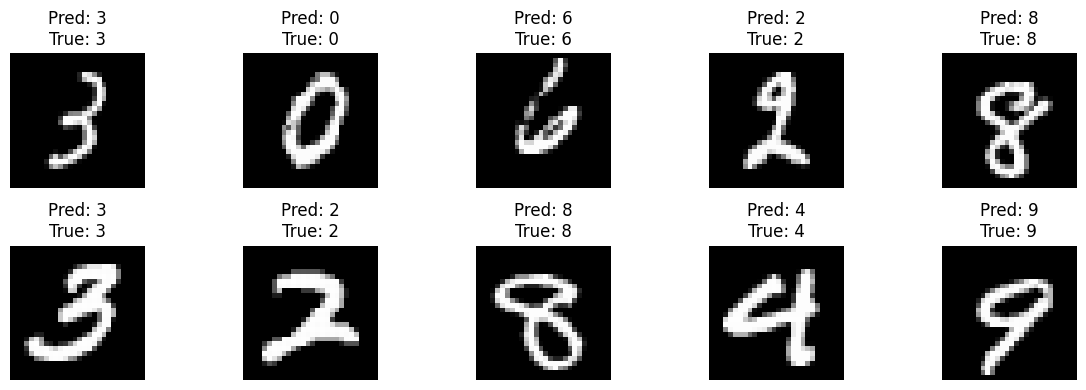

In [116]:
import matplotlib.pyplot as plt

# Put model in evaluation mode
model.eval()

# Get one batch
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

# Forward pass
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Move to CPU for plotting
images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

# Number of images to display (safe if batch < 10)
num_images = min(10, images.shape[0])

plt.figure(figsize=(12, 4))

for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [108]:
# sample a data point from the train_loader

data_point, label = next(iter(train_loader))

print("Shape of data point:", data_point.shape)
patch_embed = nn.Conv2d(num_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)
print(patch_embed(data_point).flatten(2).transpose(1,2).shape)


Shape of data point: torch.Size([64, 1, 28, 28])
torch.Size([64, 16, 64])
